In [1]:
# Подключение пакетов
import os, sys, time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

print('Numpy version:', np.version.version)

# Устанавливаем рабочую директорию в корень проекта
while not os.getcwd().endswith("hw4_nv"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.config import v1

mel_config = v1.MelConfig()
data_config = v1.DataConfig()
model_config = v1.ModelConfig()
train_config = v1.TrainConfig()

In [4]:
from IPython import display


def show_mel(data: torch.Tensor, title: str = "data example", eps=1e-5):
    """
    Преобразование входных данных в картинку и ее отображение.

    Args:
        data (torch.Tensor): вход модели в виде torch.tensor [1 x H x W] или [H x W]
        title (str): подпись к графику
    """
    if data.min() < -1 - eps or data.max() > 1 + eps:
        data = (data - data.min()) / (data.max() - data.min())
    else:
        data = (data / 2 + 0.5).clip(0, 1)
    if len(data.shape) == 3:
        data = data.squeeze(0)
    
    plt.figure(figsize=(20, 3))
    plt.imshow(data.cpu().numpy()[::-1], interpolation="lanczos", cmap="viridis")
    plt.grid()
    plt.axis("off")
    plt.title(title)
    
    plt.show()

def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr, normalize=False))

def show_data_sample(audio):
    mel, mel_loss = mel_spec(audio), mel_spec_loss(audio)
    print(mel.shape)
    show_mel(torch.cat([mel_loss, mel], dim=1))
    visualize_audio(audio)

torch.Size([1, 80, 446])


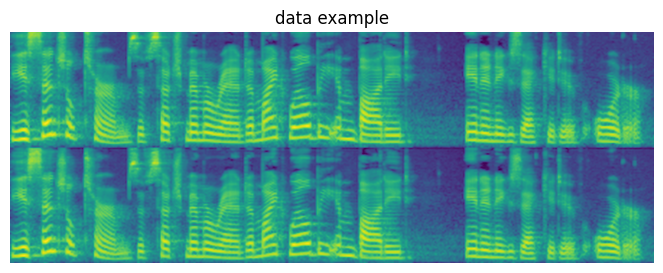

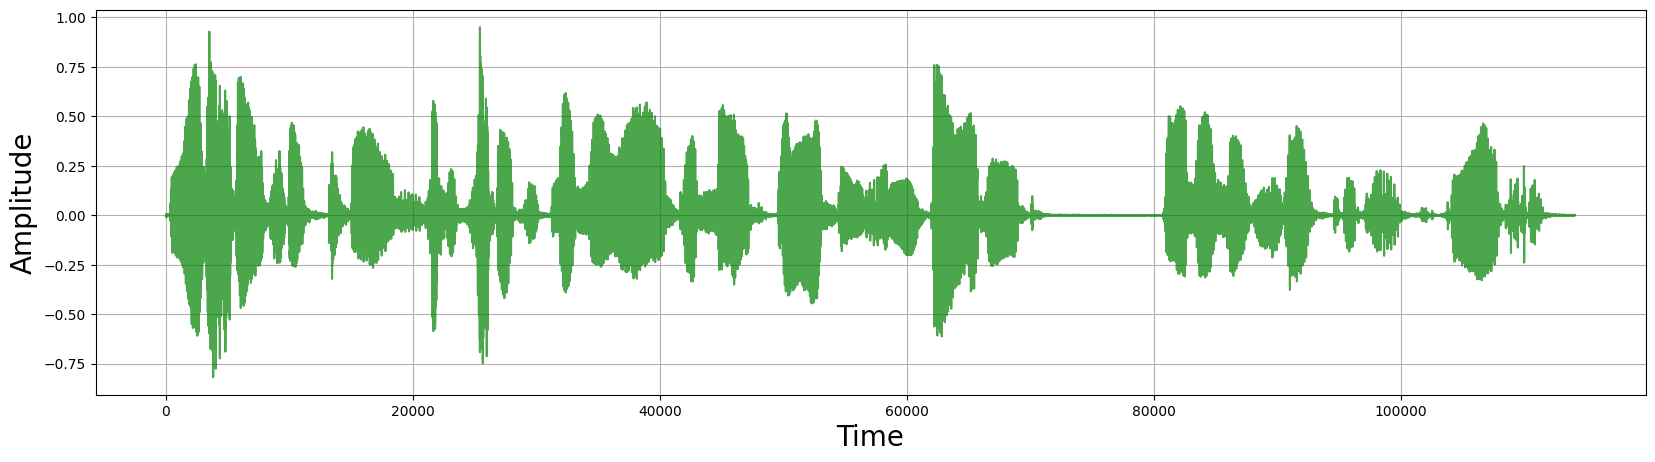

In [10]:
mel_spec = mel_config.mel_spectrogram
mel_spec_loss = mel_config.mel_spectrogram_loss
dataset = data_config.valid_dataset
show_data_sample(dataset[0])

In [11]:
train_loader = DataLoader(
    data_config.train_dataset,
    batch_size=train_config.train_batch,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

In [13]:
from tqdm import tqdm

start = time.perf_counter()
for audio in tqdm(train_loader):
    mel, mel_loss = mel_spec(audio.squeeze(1)), mel_spec_loss(audio.squeeze(1))
run_time = time.perf_counter() - start
print("%.2f s elapsed\n%.3f s per step" % (run_time, run_time / len(train_loader)))

  0%|          | 0/809 [00:00<?, ?it/s]

33.27 s elapsed
0.041 s per step


In [5]:
model = model_config.generator
model

Generator(
  (in_conv): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (upsample_blocks): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (res_blocks): ModuleList(
    (0): ModuleList(
      (0): ResBlockType1(
        (convs1): ModuleList(
          (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
          (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
        )
        (convs2): ModuleList(
          (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))

In [6]:
model = model_config.discriminator
model

Discriminator(
  (mpd): MultiPeriodDiscriminator(
    (discriminators): ModuleList(
      (0): PeriodDiscriminator(
        (convs): ModuleList(
          (0): Conv2d(1, 32, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (1): Conv2d(32, 128, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (2): Conv2d(128, 512, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (3): Conv2d(512, 1024, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (4): Conv2d(1024, 1024, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        )
        (out_conv): Conv2d(1024, 1, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      )
      (1): PeriodDiscriminator(
        (convs): ModuleList(
          (0): Conv2d(1, 32, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (1): Conv2d(32, 128, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (2): Conv2d(128, 512, kernel_size=(5, 1), stride=(3, 1), padding=(2, 0))
          (3): Conv2d(512, 102